In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.T1_measurements as T1
import analysis.plotting as plotting
import analysis.analysis as analysis
import classifiers.classifier as classifier

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")


Qubit(qubit_thr=[-10000, -600], ge_amp=1.01, ro_amp=0.25, ge_time=77, ge_ssm=-0.1144, ROIF=0.10268999999999995, ro_freq=6.72739, IQ_angle=60, ef_time=44, RO_LO_pwr=16, mixer_offset_ge=2.5, RO_LO=6.6247, ef_half_time=25, ef_half_amp=1.3, mixer_offset_ef=6, ef_ssm=-0.25684, RO_IF=None, qubit_id=q1, ro_dur=5000, ef_amp=1.5)
Qubit(qubit_thr=[-10000, 1900], ge_amp=0.4, ro_amp=0.45, ge_time=74, ge_ssm=-0.154, ROIF=0.030840000000000423, ro_freq=6.65554, IQ_angle=25, ef_time=None, RO_LO_pwr=16, mixer_offset_ge=None, RO_LO=6.6247, ef_half_time=None, ef_half_amp=None, mixer_offset_ef=None, ef_ssm=-0.2962, RO_IF=None, qubit_id=q2, ro_dur=5000, ef_amp=1)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)

In [4]:
def run_T1(
    q1,
    q2,
    general_vals_dict,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    num_steps=101
    # Run the experiment
    #(qubit1: object, qubit2: object, gen_vals: dict, sweep_time=100000, verbose=True)
    T1.T1(q1, q2, general_vals_dict, sweep_time, verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

In [5]:
def run_T1_ef(
    q1,
    q2,
    general_vals_dict,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    swap_freq=-0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    #(qubit1: object, qubit2: object, gen_vals: dict, sweep_time=100000, verbose=True)
    T1.T1_ef(q1, q2, general_vals_dict, sweep_time, swap_freq,swap_time,verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    num_steps=101
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
0, No error
Capturing 66 buffers. Press <enter> to abort
Capture completed in 21.260130 sec
Captured 66 buffers (3.104402 buffers per sec)
Captured 202752 records (9536.724408 records per sec)
Transferred 3321888768 bytes (156249692.695104 bytes per sec)


<Figure size 800x800 with 0 Axes>

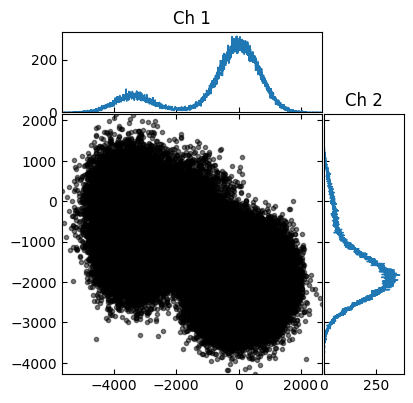

<Figure size 800x800 with 0 Axes>

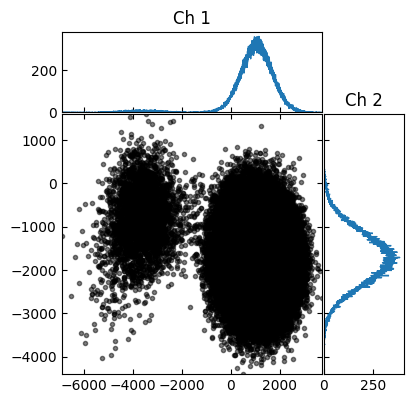

In [6]:
reps = 2000
sweep_time = 70000
values, IQ_df = run_T1_ef(q1,q2,general_vals_dict, sweep_time, reps)

In [7]:
# IQ_df = plotting.get_IQ_averages(values)
# Q = IQ_df["Q1"]
# I = IQ_df["I1"]
# Qrange = abs(np.max(Q) - np.min(Q))
# Irange = abs(np.max(I) - np.min(I))
# times = np.linspace(0, sweep_time / 1000, len(Q))
# if Qrange>Irange:
#         T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
# else:
#         T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

# print(T1_ge_fit_vals)
# T1_ge = 1/T1_ge_fit_vals[1]
# print("T1_ge = {} \u03BCs".format(T1_ge))
# Q = IQ_df["Q2"]
# I = IQ_df["I2"]
# Qrange = abs(np.max(Q) - np.min(Q))
# Irange = abs(np.max(I) - np.min(I))
# times = np.linspace(0, sweep_time / 1000, len(Q))
# if Qrange>Irange:
#         T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
# else:
#         T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

# print(T1_ge_fit_vals)
# T1_ge = 1/T1_ge_fit_vals[1]
# print("T1_ge = {} \u03BCs".format(T1_ge))


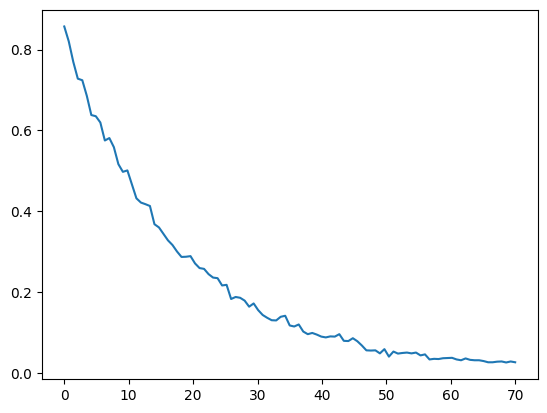

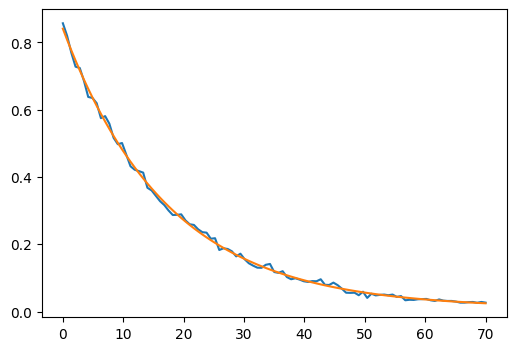



   amp: 0.831091940309028
 gamma: 0.05767753745283484
offset: 0.009919384441776565
[0.83109194 0.05767754 0.00991938]
T1_ge = 17.33777210612951 μs


In [11]:
num_steps=101
reps=2000
# classified = classifier.classify(IQ_df)
states = classified["predicted"]
# Reshape the predicted states.
# (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
#  where each row corresponds to a time step and holds all the state measurements for that step.)
states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
probabilties = classifier.probabilities(states_reshaped)
population = classifier.population(states_reshaped)

# Compute time values as the index for the DataFrame.
times = np.linspace(0, sweep_time / 1000, num_steps)

# Build a DataFrame that holds the probability vs. time.
df_prob = pd.DataFrame(
    {
        "time": times,
        "P_f": probabilties["P_f"],
        "P_e": probabilties["P_e"],
        "P_g": probabilties["P_g"],
    },
    index=times,
)
plt.plot(df_prob["time"], df_prob["P_f"], label="P_f")
T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(df_prob["time"],df_prob["P_f"],guess_vals=[-1,0.5,0])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))